# Computing the correct combination of channels

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate as integr
import sympy as sp
sns.set_context('notebook')
%matplotlib inline
sp.init_printing() 


# Plot Twitch2B spectra

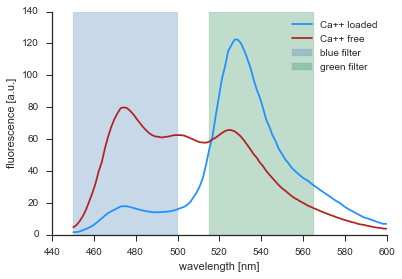

In [3]:
loaded = pd.read_csv('twitch2B_loaded.csv')
free = pd.read_csv('twitch2B_free.csv')
with sns.axes_style('ticks'):
    fig, ax = plt.subplots()

blue_filter = [450,500] 
green_filter = [515,565]
x = np.linspace(np.min(free.wavelength), np.max(free.wavelength), 100)
y_loaded = np.interp(x, loaded.wavelength, loaded.fluorescence)
y_free   = np.interp(x, free.wavelength, free.fluorescence)
f_loaded = lambda xx:  np.interp(xx, x, y_loaded)
f_free = lambda xx:  np.interp(xx, x, y_free)
    
ax.plot(x, f_loaded(x), label='Ca++ loaded', color='dodgerblue')
ax.plot(x, f_free(x), label='Ca++ free', color='firebrick')
ax.fill_between(blue_filter,[0,0],[140,140],color='steelblue', label='blue filter', alpha=.3)
ax.fill_between(green_filter,[0,0],[140,140],color='seagreen', label='green filter', alpha=.3)
ax.legend()
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('fluorescence [a.u.]')
sns.despine(fig)


# Compute theoretical fluorescence for filters

In [4]:
b_free = integr.quad(f_free, *blue_filter)[0]
b_loaded = integr.quad(f_loaded, *blue_filter)[0]

g_free = integr.quad(f_free, *green_filter)[0]
g_loaded = integr.quad(f_loaded, *green_filter)[0]

for name, val in zip(['b_free', 'b_loaded', 'g_free', 'g_loaded'],[b_free, b_loaded, g_free, g_loaded]):
    print(name,'=',val)

    

b_free = 2716.157561602762
b_loaded = 616.0042373716336
g_free = 2172.9250865645613
g_loaded = 3738.649400881034


/usr/local/lib/python3.4/dist-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


# Compute the fraction of loaded fluorophores

In [5]:
b_on, b_off, g_on, g_off, g, c, a, b, x, r, Fg, Fb = sp.symbols("b_+ b_- g_+ g_- gamma c alpha beta x r F_g F_b")
db, dg = sp.symbols("Delta_b Delta_g")
fb = a*c*(x*b_on + (1-x)*b_off)
fg = b*c*(x*g_on + (1-x)*g_off)


The fluorescence for the green and blue channel as a function of loaded fluorophores are given by 

In [6]:
fb

In [7]:
fg

where $\alpha$ and $\beta$ are unknown scaling factors that include the filter attenuation as well as the gain of the photomultiplier. We estimate the ratio $\beta/\alpha$ from the slope of a linear regression from the green into the blue channel. 

We use $\Delta_g=g_+-g_-$, $\Delta_b=b_+-b_-$, as well as $F_g$ for the measured fuorescence in the green channel. 

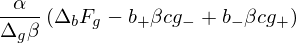

In [9]:
fb.subs([(x, sp.solve(Fg - fg, x)[0])]).simplify().collect(Fg).subs([(b_on-b_off, db), (g_on-g_off, dg)])

Therefore $\gamma = \frac{\Delta_b}{\Delta_g\cdot a}$ where $a$ is the slope of the computed regression. 

# Compute fraction of loaded fluororphores using $\frac{f_g - f_b}{f_b + f_g}$

In the unsaturated setting, the fraction of loaded fluorophores $x$ is proportional to the concentration of Calcium. We compute $x$ from the fraction $\frac{f_g - f_b}{f_b + f_g}$ to avoid division by zero. 

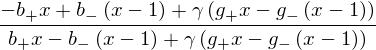

In [10]:
rat = ((fg-fb)/(fg+fb)).simplify().subs([(b,g),(a,1)]) # substitute gamma for beta/alpha
rat

Solve for $x$

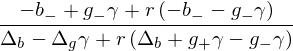

In [11]:
eq = r - rat
x0 = sp.solve(eq,x)[0].collect([r,g]).subs([(b_on-b_off, db), (g_on-g_off, dg)])
x0
